In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
%matplotlib widget

In [3]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

### Reference: Influence of hole shape on sound absorption of underwater anechoic layers
#### https://www.sciencedirect.com/science/article/abs/pii/S0022460X1830227X

### Import pre-defined class and function

In [4]:
%run -i hole_shape_sound_absorption.py

### Define the determinant of the coefficient matrix of eq(14) in the paper

In [5]:
determinant, mat = determinant_from_matrix()
mat

Matrix([
[                                                                                                              -sqrt(-kz**2 + omega**2/cl**2)*besselj(1, b*sqrt(-kz**2 + omega**2/cl**2)),                                                                                                               -sqrt(-kz**2 + omega**2/cl**2)*bessely(1, b*sqrt(-kz**2 + omega**2/cl**2)),                                                                                      -I*kz*sqrt(-kz**2 + omega**2/ct**2)*besselj(1, b*sqrt(-kz**2 + omega**2/ct**2)),                                                                                      -I*kz*sqrt(-kz**2 + omega**2/ct**2)*bessely(1, b*sqrt(-kz**2 + omega**2/ct**2))],
[(-2*mu*(-kz**2 + omega**2/cl**2) - lambda*omega**2/cl**2)*besselj(0, a*sqrt(-kz**2 + omega**2/cl**2)) + 2*mu*sqrt(-kz**2 + omega**2/cl**2)*besselj(1, a*sqrt(-kz**2 + omega**2/cl**2))/a, (-2*mu*(-kz**2 + omega**2/cl**2) - lambda*omega**2/cl**2)*bessely(0, a*sqrt(-kz**2 + omega**2/cl**

## Define an object of sound_performance for calculating sound absorption
### The default values are listed as below (all in SI units)

Material of anechoic layer: rubber

Young's modulus of rubber (GPa): 0.14

Loss factor of rubber 0.23

Poisson ratio of rubber 0.49

Density of rubber (kg/m3): 1100

Density of air (kg/m3): 1.21

Shape: cone

p = 4 mm

q = 8 mm

lh = 40 mm

cell_radius = 15 mm

num_segments = 100

Density of water (kg/m3): 998

Sound speed of water (m/s): 1483

#### https://en.wikipedia.org/wiki/Lam%C3%A9_parameters

### Define the frequency array by np.arange

In [6]:
frequency_array = np.arange(2, 10052, 100)
# frequency_array2 = np.arange(2, 10022, 20)
frequency_array.shape

(101,)

### Example 01: define all parameters by anechoic_sound_absorption()

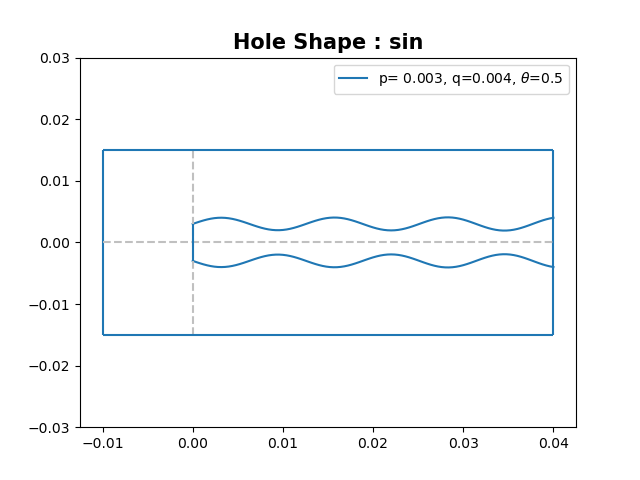

Solving wavenumber in determinant for shape = sin, p = 0.003, q = 0.004, Young's = 140000000.0


Solving for all frequencies:   0%|          | 0/101 [00:00<?, ?it/s]

  ... working at frequency = 2.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 102.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 202.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 302.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 402.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 502.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 602.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 702.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 802.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 902.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 1002.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 1102.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 1202.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 1302.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 1402.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 1502.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 1602.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 1702.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 1802.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 1902.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 2002.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 2102.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 2202.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 2302.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 2402.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 2502.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 2602.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 2702.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 2802.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 2902.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 3002.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 3102.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 3202.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 3302.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 3402.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 3502.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 3602.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 3702.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 3802.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 3902.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 4002.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 4102.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 4202.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 4302.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 4402.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 4502.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 4602.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 4702.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 4802.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 4902.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 5002.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 5102.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 5202.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 5302.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 5402.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 5502.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 5602.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 5702.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 5802.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 5902.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 6002.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 6102.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 6202.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 6302.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 6402.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 6502.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 6602.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 6702.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 6802.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 6902.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 7002.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 7102.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 7202.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 7302.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 7402.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 7502.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 7602.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 7702.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 7802.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 7902.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 8002.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 8102.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 8202.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 8302.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 8402.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 8502.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 8602.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 8702.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 8802.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 8902.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 9002.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 9102.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 9202.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 9302.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 9402.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 9502.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 9602.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 9702.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 9802.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 9902.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 10002.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]



self.frequency_array.shape[0] = 101 is same as self.wavenumer_array.shape[0] = 101
Save file to /Users/chenghunglin/Documents/sin_3_4_05_vol.xlsx


In [7]:
sin_3_4_05_vol = anechoic_sound_absorption(determinant, frequency_array,
                              fp = '/Users/chenghunglin/Documents/', 
                              fn = 'sin_3_4_05_vol.xlsx', 
                              material='rubber', shape='sin', 
                              p=3e-3, q=4e-3, lh=40e-3, cell_radius=15e-3, 
                              theta=0.5, phi=3e-3, length_unit='m',
                              num_segments=100, layer_density=1100, air_density=1.21, 
                              Young_modulus=0.14e9, Poisson_ratio=0.49, loss_factor=0.23, 
                              medium_density=998, sound_speed_medium=1483, 
                              use_volume=True)

self.frequency_array.shape[0] = 101 is same as self.wavenumer_array.shape[0] = 101


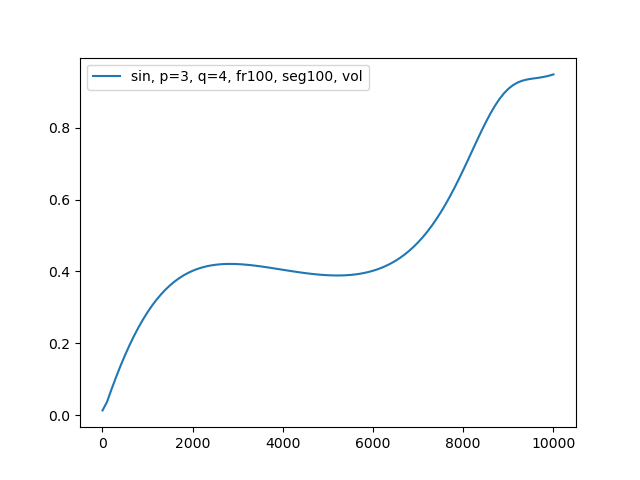

In [8]:
plt.figure()
plt.plot(sin_3_4_05_vol.frequency_array, sin_3_4_05_vol.absorption_frequency(), label='sin, p=3, q=4, fr100, seg100, vol')
# plt.plot(cone_4_8.frequency_array, cone_4_8.absorption_frequency(), label='cone, p=4, q=8, Young=0.14 Gpa')
# plt.plot(cone_4_8_3.frequency_array, cone_4_8_3.absorption_frequency(), '--', color='orange', label='cone, p=4, q=8, Young=0.014 Gpa')
# plt.plot(horn_1_11.frequency_array, horn_1_11.absorption_frequency(), label='horn, p=1, q=11, seg=50, fr=50')
# plt.plot(horn_1_11_seg100.frequency_array, horn_1_11_seg100.absorption_frequency(), label='horn, p=1, q=11, seg=100, fr=50')
# plt.plot(horn_1_11_fr20.frequency_array, horn_1_11_fr20.absorption_frequency(), label='horn, p=1, q=11, seg=100, fr=20')
plt.legend()

### Example 01-1: compare using effective radius

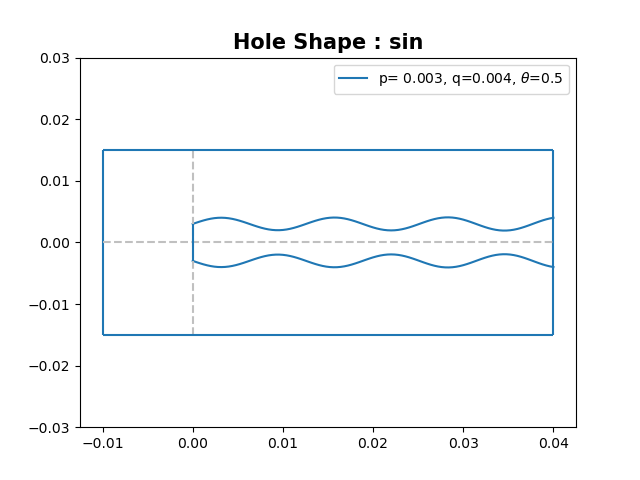

Solving wavenumber in determinant for shape = sin, p = 0.003, q = 0.004, Young's = 140000000.0


Solving for all frequencies:   0%|          | 0/101 [00:00<?, ?it/s]

  ... working at frequency = 2.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 102.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 202.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 302.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 402.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 502.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 602.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 702.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 802.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 902.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 1002.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 1102.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 1202.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 1302.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 1402.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 1502.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 1602.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 1702.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 1802.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 1902.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 2002.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 2102.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 2202.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 2302.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 2402.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 2502.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 2602.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 2702.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 2802.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 2902.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 3002.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 3102.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 3202.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 3302.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 3402.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 3502.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 3602.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 3702.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 3802.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 3902.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 4002.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 4102.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 4202.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 4302.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 4402.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 4502.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 4602.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 4702.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 4802.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 4902.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 5002.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 5102.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 5202.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 5302.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 5402.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 5502.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 5602.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 5702.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 5802.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 5902.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 6002.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 6102.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 6202.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 6302.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 6402.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 6502.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 6602.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 6702.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 6802.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 6902.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 7002.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 7102.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 7202.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 7302.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 7402.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 7502.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 7602.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 7702.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 7802.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 7902.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 8002.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 8102.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 8202.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 8302.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 8402.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 8502.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 8602.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 8702.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 8802.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 8902.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 9002.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 9102.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 9202.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 9302.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 9402.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 9502.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 9602.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 9702.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 9802.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 9902.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 10002.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]



self.frequency_array.shape[0] = 101 is same as self.wavenumer_array.shape[0] = 101
Save file to /Users/chenghunglin/Documents/sin_3_4_05_rad.xlsx


In [9]:
sin_3_4_05_rad = anechoic_sound_absorption(determinant, frequency_array,
                              fp = '/Users/chenghunglin/Documents/', 
                              fn = 'sin_3_4_05_rad.xlsx', 
                              material='rubber', shape='sin', 
                              p=3e-3, q=4e-3, lh=40e-3, cell_radius=15e-3, 
                              theta=0.5, phi=3e-3, length_unit='m',
                              num_segments=100, layer_density=1100, air_density=1.21, 
                              Young_modulus=0.14e9, Poisson_ratio=0.49, loss_factor=0.23, 
                              medium_density=998, sound_speed_medium=1483, 
                              use_volume=False)

self.frequency_array.shape[0] = 101 is same as self.wavenumer_array.shape[0] = 101
self.frequency_array.shape[0] = 101 is same as self.wavenumer_array.shape[0] = 101


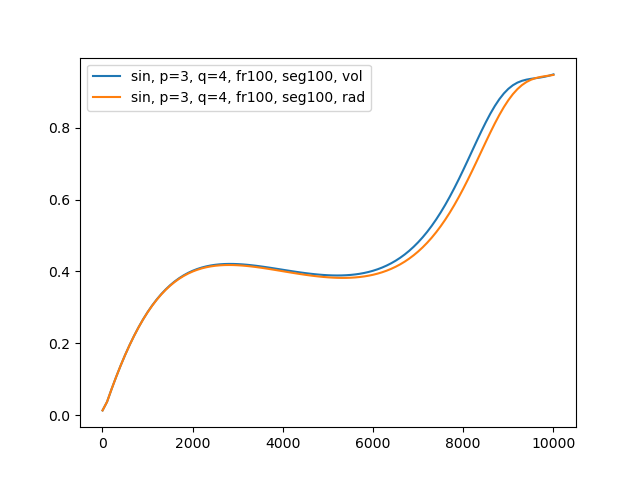

In [10]:
plt.figure()
plt.plot(sin_3_4_05_vol.frequency_array, sin_3_4_05_vol.absorption_frequency(), label='sin, p=3, q=4, fr100, seg100, vol')
plt.plot(sin_3_4_05_rad.frequency_array, sin_3_4_05_rad.absorption_frequency(), label='sin, p=3, q=4, fr100, seg100, rad')
# plt.plot(horn_1_11.frequency_array, horn_1_11.absorption_frequency(), label='horn, p=1, q=11, volume')
plt.legend()

### Example 01-2: compare finer frequency & segment steps

In [11]:
frequency_array = np.arange(2, 10052, 50)

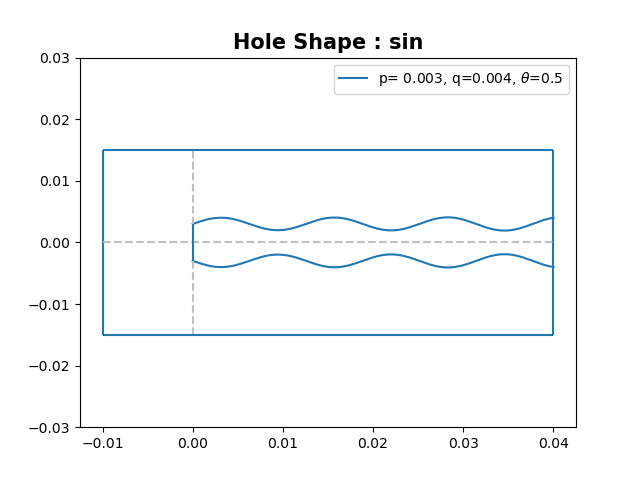

Solving wavenumber in determinant for shape = sin, p = 0.003, q = 0.004, Young's = 140000000.0


Solving for all frequencies:   0%|          | 0/201 [00:00<?, ?it/s]

  ... working at frequency = 2.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 52.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 102.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 152.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 202.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 252.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 302.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 352.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 402.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 452.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 502.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 552.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 602.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 652.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 702.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 752.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 802.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 852.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 902.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 952.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 1002.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 1052.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 1102.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 1152.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 1202.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 1252.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 1302.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 1352.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 1402.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 1452.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 1502.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 1552.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 1602.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 1652.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 1702.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 1752.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 1802.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 1852.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 1902.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 1952.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 2002.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 2052.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 2102.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 2152.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 2202.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 2252.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 2302.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 2352.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 2402.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 2452.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 2502.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 2552.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 2602.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 2652.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 2702.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 2752.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 2802.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 2852.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 2902.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 2952.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 3002.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 3052.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 3102.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 3152.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 3202.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 3252.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 3302.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 3352.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 3402.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 3452.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 3502.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 3552.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 3602.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 3652.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 3702.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 3752.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 3802.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 3852.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 3902.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 3952.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 4002.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 4052.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 4102.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 4152.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 4202.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 4252.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 4302.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 4352.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 4402.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 4452.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 4502.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 4552.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 4602.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 4652.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 4702.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 4752.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 4802.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 4852.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 4902.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 4952.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 5002.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 5052.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 5102.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 5152.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 5202.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 5252.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 5302.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 5352.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 5402.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 5452.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 5502.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 5552.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 5602.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 5652.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 5702.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 5752.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 5802.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 5852.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 5902.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 5952.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 6002.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 6052.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 6102.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 6152.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 6202.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 6252.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 6302.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 6352.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 6402.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 6452.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 6502.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 6552.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 6602.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 6652.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 6702.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 6752.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 6802.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 6852.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 6902.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 6952.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 7002.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 7052.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 7102.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 7152.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 7202.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 7252.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 7302.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 7352.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 7402.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 7452.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 7502.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 7552.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 7602.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 7652.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 7702.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 7752.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 7802.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 7852.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 7902.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 7952.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 8002.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 8052.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 8102.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 8152.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 8202.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 8252.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 8302.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 8352.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 8402.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 8452.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 8502.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 8552.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 8602.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 8652.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 8702.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 8752.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 8802.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 8852.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 8902.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 8952.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 9002.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 9052.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 9102.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 9152.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 9202.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 9252.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 9302.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 9352.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 9402.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 9452.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 9502.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 9552.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 9602.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 9652.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 9702.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 9752.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 9802.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 9852.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 9902.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 9952.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 10002.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]



self.frequency_array.shape[0] = 201 is same as self.wavenumer_array.shape[0] = 201
Save file to /Users/chenghunglin/Documents/sin_3_4_05_vol_2.xlsx


In [12]:
sin_3_4_05_vol_2 = anechoic_sound_absorption(determinant, frequency_array,
                              fp = '/Users/chenghunglin/Documents/', 
                              fn = 'sin_3_4_05_vol_2.xlsx', 
                              material='rubber', shape='sin', 
                              p=3e-3, q=4e-3, lh=40e-3, cell_radius=15e-3, 
                              theta=0.5, phi=3e-3, length_unit='m',
                              num_segments=200, layer_density=1100, air_density=1.21, 
                              Young_modulus=0.14e9, Poisson_ratio=0.49, loss_factor=0.23, 
                              medium_density=998, sound_speed_medium=1483, 
                              use_volume=True)

self.frequency_array.shape[0] = 101 is same as self.wavenumer_array.shape[0] = 101
self.frequency_array.shape[0] = 101 is same as self.wavenumer_array.shape[0] = 101
self.frequency_array.shape[0] = 201 is same as self.wavenumer_array.shape[0] = 201


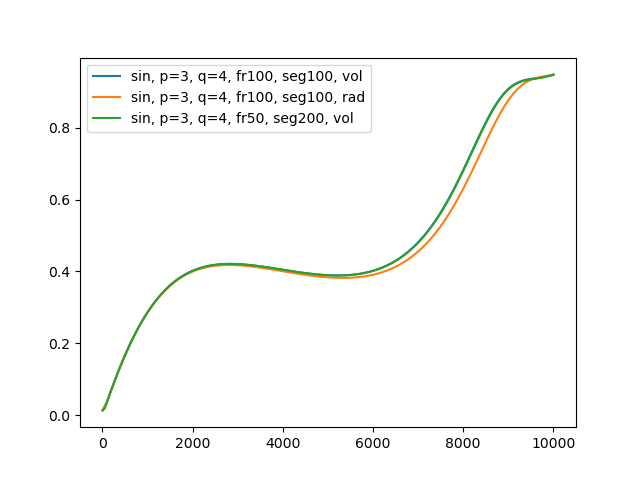

In [13]:
plt.figure()
plt.plot(sin_3_4_05_vol.frequency_array, sin_3_4_05_vol.absorption_frequency(), label='sin, p=3, q=4, fr100, seg100, vol')
plt.plot(sin_3_4_05_rad.frequency_array, sin_3_4_05_rad.absorption_frequency(), label='sin, p=3, q=4, fr100, seg100, rad')
plt.plot(sin_3_4_05_vol_2.frequency_array, sin_3_4_05_vol_2.absorption_frequency(), label='sin, p=3, q=4, fr50, seg200, vol')
# plt.plot(horn_1_11.frequency_array, horn_1_11.absorption_frequency(), label='horn, p=1, q=11, volume')
plt.legend()

In [14]:
frequency_array = np.arange(2, 10052, 50)

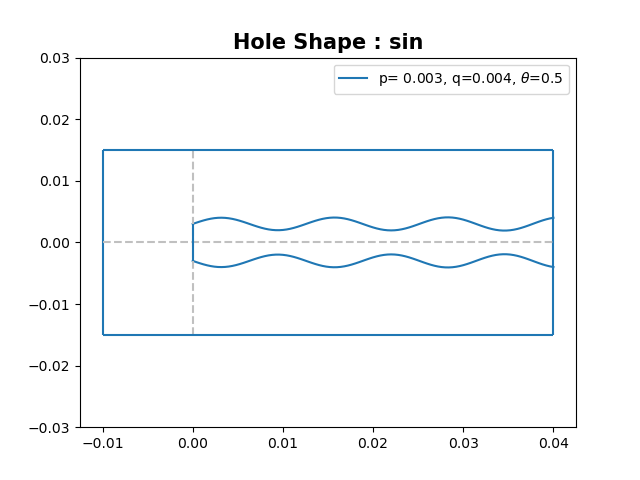

Solving wavenumber in determinant for shape = sin, p = 0.003, q = 0.004, Young's = 140000000.0


Solving for all frequencies:   0%|          | 0/201 [00:00<?, ?it/s]

  ... working at frequency = 2.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 52.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 102.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 152.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 202.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 252.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 302.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 352.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 402.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 452.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 502.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 552.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 602.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 652.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 702.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 752.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 802.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 852.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 902.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 952.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 1002.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 1052.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 1102.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 1152.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 1202.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 1252.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 1302.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 1352.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 1402.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 1452.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 1502.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 1552.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 1602.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 1652.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 1702.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 1752.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 1802.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 1852.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 1902.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 1952.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 2002.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 2052.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 2102.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 2152.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 2202.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 2252.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 2302.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 2352.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 2402.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 2452.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 2502.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 2552.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 2602.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 2652.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 2702.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 2752.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 2802.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 2852.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 2902.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 2952.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 3002.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 3052.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 3102.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 3152.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 3202.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 3252.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 3302.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 3352.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 3402.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 3452.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 3502.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 3552.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 3602.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 3652.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 3702.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 3752.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 3802.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 3852.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 3902.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 3952.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 4002.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 4052.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 4102.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 4152.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 4202.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 4252.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 4302.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 4352.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 4402.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 4452.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 4502.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 4552.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 4602.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 4652.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 4702.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 4752.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 4802.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 4852.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 4902.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 4952.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 5002.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 5052.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 5102.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 5152.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 5202.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 5252.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 5302.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 5352.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 5402.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 5452.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 5502.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 5552.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 5602.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 5652.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 5702.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 5752.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 5802.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 5852.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 5902.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 5952.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 6002.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 6052.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 6102.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 6152.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 6202.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 6252.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 6302.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 6352.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 6402.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 6452.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 6502.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 6552.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 6602.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 6652.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 6702.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 6752.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 6802.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 6852.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 6902.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 6952.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 7002.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 7052.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 7102.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 7152.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 7202.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 7252.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 7302.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 7352.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 7402.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 7452.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 7502.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 7552.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 7602.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 7652.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 7702.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 7752.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 7802.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 7852.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 7902.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 7952.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 8002.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 8052.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 8102.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 8152.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 8202.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 8252.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 8302.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 8352.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 8402.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 8452.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 8502.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 8552.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 8602.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 8652.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 8702.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 8752.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 8802.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 8852.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 8902.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 8952.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 9002.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 9052.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 9102.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 9152.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 9202.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 9252.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 9302.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 9352.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 9402.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 9452.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 9502.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 9552.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 9602.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 9652.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 9702.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 9752.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 9802.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 9852.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 9902.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 9952.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 10002.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]



self.frequency_array.shape[0] = 201 is same as self.wavenumer_array.shape[0] = 201
Save file to /Users/chenghunglin/Documents/sin_3_4_05_vol_3.xlsx


In [15]:
sin_3_4_05_vol_3 = anechoic_sound_absorption(determinant, frequency_array,
                              fp = '/Users/chenghunglin/Documents/', 
                              fn = 'sin_3_4_05_vol_3.xlsx', 
                              material='rubber', shape='sin', 
                              p=3e-3, q=4e-3, lh=40e-3, cell_radius=15e-3, 
                              theta=0.5, phi=3e-3, length_unit='m',
                              num_segments=100, layer_density=1100, air_density=1.21, 
                              Young_modulus=0.14e9, Poisson_ratio=0.49, loss_factor=0.23, 
                              medium_density=998, sound_speed_medium=1483, 
                              use_volume=True)

self.frequency_array.shape[0] = 101 is same as self.wavenumer_array.shape[0] = 101
self.frequency_array.shape[0] = 201 is same as self.wavenumer_array.shape[0] = 201
self.frequency_array.shape[0] = 201 is same as self.wavenumer_array.shape[0] = 201


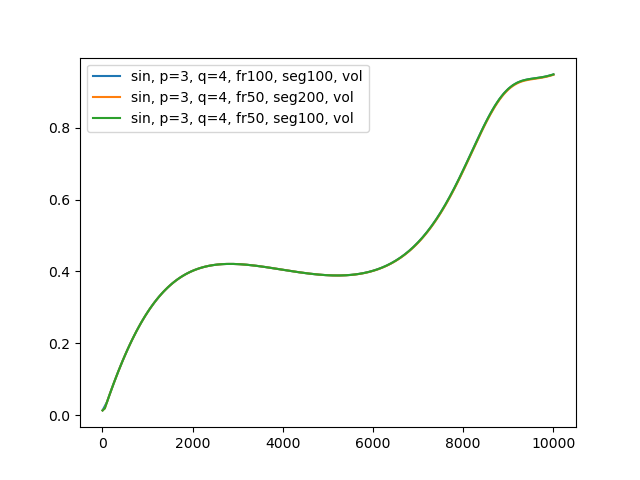

In [16]:
plt.figure()
plt.plot(sin_3_4_05_vol.frequency_array, sin_3_4_05_vol.absorption_frequency(), label='sin, p=3, q=4, fr100, seg100, vol')
# plt.plot(sin_3_4_05_rad.frequency_array, sin_3_4_05_rad.absorption_frequency(), label='sin, p=3, q=4, fr100, seg100, rad')
plt.plot(sin_3_4_05_vol_2.frequency_array, sin_3_4_05_vol_2.absorption_frequency(), label='sin, p=3, q=4, fr50, seg200, vol')
plt.plot(sin_3_4_05_vol_3.frequency_array, sin_3_4_05_vol_3.absorption_frequency(), label='sin, p=3, q=4, fr50, seg100, vol')
plt.legend()

In [17]:
frequency_array = np.arange(2, 10052, 100)

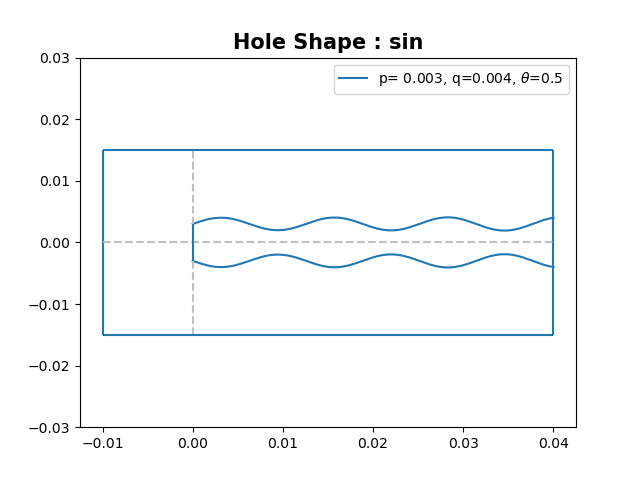

Solving wavenumber in determinant for shape = sin, p = 0.003, q = 0.004, Young's = 140000000.0


Solving for all frequencies:   0%|          | 0/101 [00:00<?, ?it/s]

  ... working at frequency = 2.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 102.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 202.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 302.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 402.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 502.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 602.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 702.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 802.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 902.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 1002.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 1102.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 1202.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 1302.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 1402.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 1502.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 1602.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 1702.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 1802.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 1902.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 2002.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 2102.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 2202.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 2302.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 2402.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 2502.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 2602.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 2702.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 2802.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 2902.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 3002.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 3102.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 3202.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 3302.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 3402.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 3502.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 3602.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 3702.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 3802.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 3902.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 4002.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 4102.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 4202.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 4302.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 4402.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 4502.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 4602.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 4702.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 4802.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 4902.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 5002.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 5102.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 5202.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 5302.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 5402.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 5502.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 5602.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 5702.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 5802.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 5902.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 6002.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 6102.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 6202.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 6302.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 6402.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 6502.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 6602.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 6702.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 6802.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 6902.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 7002.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 7102.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 7202.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 7302.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 7402.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 7502.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 7602.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 7702.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 7802.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 7902.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 8002.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 8102.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 8202.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 8302.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 8402.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 8502.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 8602.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 8702.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 8802.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 8902.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 9002.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 9102.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 9202.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 9302.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 9402.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 9502.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 9602.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 9702.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 9802.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 9902.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]

  ... working at frequency = 10002.0 Hz:   0%|          | 0/200 [00:00<?, ?it/s]



self.frequency_array.shape[0] = 101 is same as self.wavenumer_array.shape[0] = 101
Save file to /Users/chenghunglin/Documents/sin_3_4_05_vol_4.xlsx


In [18]:
sin_3_4_05_vol_4 = anechoic_sound_absorption(determinant, frequency_array,
                              fp = '/Users/chenghunglin/Documents/', 
                              fn = 'sin_3_4_05_vol_4.xlsx', 
                              material='rubber', shape='sin', 
                              p=3e-3, q=4e-3, lh=40e-3, cell_radius=15e-3, 
                              theta=0.5, phi=3e-3, length_unit='m',
                              num_segments=200, layer_density=1100, air_density=1.21, 
                              Young_modulus=0.14e9, Poisson_ratio=0.49, loss_factor=0.23, 
                              medium_density=998, sound_speed_medium=1483, 
                              use_volume=True)

self.frequency_array.shape[0] = 101 is same as self.wavenumer_array.shape[0] = 101
self.frequency_array.shape[0] = 201 is same as self.wavenumer_array.shape[0] = 201
self.frequency_array.shape[0] = 201 is same as self.wavenumer_array.shape[0] = 201
self.frequency_array.shape[0] = 101 is same as self.wavenumer_array.shape[0] = 101


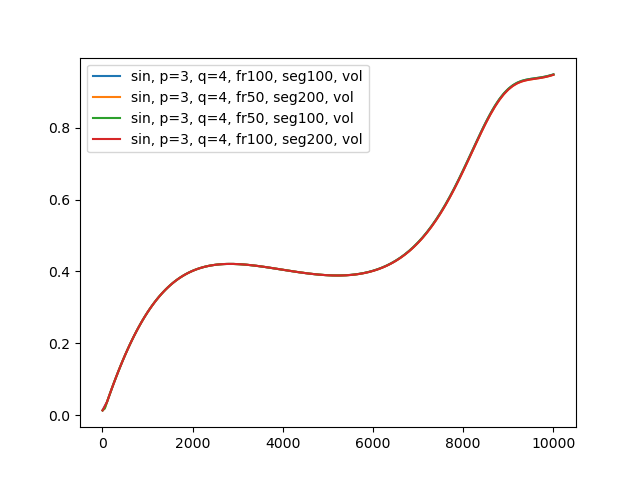

In [19]:
plt.figure()
plt.plot(sin_3_4_05_vol.frequency_array, sin_3_4_05_vol.absorption_frequency(), label='sin, p=3, q=4, fr100, seg100, vol')
# plt.plot(sin_3_4_05_rad.frequency_array, sin_3_4_05_rad.absorption_frequency(), label='sin, p=3, q=4, fr100, seg100, rad')
plt.plot(sin_3_4_05_vol_2.frequency_array, sin_3_4_05_vol_2.absorption_frequency(), label='sin, p=3, q=4, fr50, seg200, vol')
plt.plot(sin_3_4_05_vol_3.frequency_array, sin_3_4_05_vol_3.absorption_frequency(), label='sin, p=3, q=4, fr50, seg100, vol')
plt.plot(sin_3_4_05_vol_4.frequency_array, sin_3_4_05_vol_4.absorption_frequency(), label='sin, p=3, q=4, fr100, seg200, vol')
plt.legend()

### Example 02: change parameters through sound_performance() objects

In [20]:
# horn_1_11 = sound_performance(determinant, frequency_array)

In [21]:
# horn_1_11.shape = 'horn'
# horn_1_11.p_hole = 1e-3
# horn_1_11.q_hole = 11e-3

In [22]:
# ## Find roots of wavenumber in the equation of determinant
# horn_1_11.wavenumer_array, horn_1_11.failed_root = horn_1_11.axial_wavenumber_array()

In [23]:
# ## Save the data
# fp = '/Users/chenghunglin/Documents/'
# fn = 'horn_1_11.xlsx'
# horn_1_11.save_data(fp, fn)

## Plot data to compare with the paper

In [24]:
# plt.figure()
# # plt.plot(cone_4_8.frequency_array, cone_4_8.absorption_frequency(), label='cone, p=4, q=8, Young=0.14 Gpa')
# # plt.plot(cone_4_8_1.frequency_array, cone_4_8_1.absorption_frequency(), label='cone, p=4, q=8, Young=0.014 Gpa')
# # plt.plot(cone_4_8_3.frequency_array, cone_4_8_3.absorption_frequency(), '--', color='orange', label='cone, p=4, q=8, Young=0.014 Gpa')
# plt.plot(horn_1_11.frequency_array, horn_1_11.absorption_frequency(), label='horn, p=1, q=11')
# plt.legend()

In [25]:
# plt.figure()
# plt.plot(cone_4_8.frequency_array, cone_4_8.absorption_frequency(), color='blue', label='cone, p=4, q=8, Young=0.14 Gpa, step=200Hz')
# plt.plot(cone_4_8_4.frequency_array, cone_4_8_4.absorption_frequency(), '--', color='blue',label='cone, p=4, q=8, Young=0.14 Gpa, step=25Hz')
# plt.plot(cone_4_8_1.frequency_array, cone_4_8_1.absorption_frequency(), color='orange', label='cone, p=4, q=8, Young=0.014 Gpa, step=200Hz')
# plt.plot(cone_4_8_5.frequency_array, cone_4_8_5.absorption_frequency(), '--', color='orange', label='cone, p=4, q=8, Young=0.014 Gpa, step=25Hz')
# plt.plot(horn_1_11.frequency_array, horn_1_11.absorption_frequency(), label='horn, p=1, q=11')
# legend_properties = {'weight':'regular', 'size':8}    
# plt.legend(prop=legend_properties, loc='upper left') #, bbox_to_anchor=(1, 0.5))
# plt.legend()